## Import and Libraries

In [1]:
#!pip install evaluate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import evaluate
import plotly.express as px
from matplotlib import pyplot as plt
import keras
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(42)
seed = 42
tf.random.set_seed(42)

## Dataset

In [4]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all", trust_remote_code=True)
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [5]:
# Splitting data into training and validation
df = gtzan['train'].train_test_split(seed = seed, shuffle = True, test_size = .25)
df

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 749
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 250
    })
})

In [6]:
df['train']

Dataset({
    features: ['file', 'audio', 'genre'],
    num_rows: 749
})

In [7]:
temp = df['test'].train_test_split(seed = seed, shuffle = True, test_size = .5)
df['validation'] = temp['train']
df['test'] = temp['test']
print(df['validation'].shape, df['test'].shape)

(125, 3) (125, 3)


Split dataset into training (70%) and test set (30%)

### Inspect

In [8]:
id = 5
print("file:", df['train'][id]['file'])
print('\n')
print("audio: ", df['train'][id]['audio'])
print('\n')
print("genre:", df['train'][id]['genre'])
print('\n')

file: C:\Users\andre\.cache\huggingface\datasets\downloads\extracted\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\genres\jazz\jazz.00042.wav


audio:  {'path': 'C:\\Users\\andre\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\\genres\\jazz\\jazz.00042.wav', 'array': array([ 0.04382324,  0.06265259,  0.04187012, ..., -0.11987305,
       -0.14324951, -0.14401245]), 'sampling_rate': 22050}


genre: 5




In [9]:
df['train'][id]['audio']['array']

array([ 0.04382324,  0.06265259,  0.04187012, ..., -0.11987305,
       -0.14324951, -0.14401245])

The following information are retrieved:
*   file = audio path
*   audio = represented by 1 dimensional array and relative sampling rate of 22,050 Hz
*   genre = family of song (integer)



In [10]:
id2label_function = df['train'].features['genre'].int2str

# Collect all unique genre IDs
unique_genre_ids = set([sample['genre'] for sample in df['train']])

# Create a mapping of genre IDs to labels
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

# Display the distinct genres with their IDs
print("Distinct Genres and their IDs:")
for genre_id, genre_label in sorted(genre_mapping.items()):
    print(f"ID: {genre_id}, Genre: {genre_label}")

Distinct Genres and their IDs:
ID: 0, Genre: blues
ID: 1, Genre: classical
ID: 2, Genre: country
ID: 3, Genre: disco
ID: 4, Genre: hiphop
ID: 5, Genre: jazz
ID: 6, Genre: metal
ID: 7, Genre: pop
ID: 8, Genre: reggae
ID: 9, Genre: rock


In [11]:
sampling_rate_check = None
all_same = True

# Iterating through each sample
for set_name in ['train', 'test']: # Iterating through both sets
    for sample in df[set_name]:
        sampling_rate = sample['audio']['sampling_rate']

        if sampling_rate_check is None:
            sampling_rate_check = sampling_rate
        else:
            if sampling_rate != sampling_rate_check:
                all_same = False
            break

# Printing result
if all_same:
    print(f"All samples have the same sampling rate: {sampling_rate_check} Hz")
else:
    print("The samples in the dataframe have different sampling rates.")

All samples have the same sampling rate: 22050 Hz


In [12]:
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'
labels = {} # Initializing empty list

# Defining a function to count labels
def count_genres(df):
    for sample in df:
        genre_label = id2label_function(sample['genre'])

        if genre_label in labels:
            labels[genre_label] += 1

        else:
            labels[genre_label] = 1

# Counting labels in both sets
count_genres(df['train'])
count_genres(df['validation'])
count_genres(df['test'])

# Obtaining genres and count values
genres = list(labels.keys())
counts = list(labels.values())

# Plotting bar plot
fig = px.bar(x = genres, y = counts, text = counts)
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(title = '<b>Genre Counts</b>', showlegend = True, height = 500, width = 750,
                 plot_bgcolor=bg_color,paper_bgcolor=paper_color)
fig.update_yaxes(title_text = '<b>Count</b>')
fig.update_xaxes(title = '<b>Genres</b>')

fig.show()

In [35]:
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'

# Inizializzazione del dizionario dei conteggi
labels = {}

# Funzione per contare le istanze di ogni genere
def count_genres(dataset):
    labels.clear()  # Puliamo i conteggi per assicurarci di considerare solo il test set
    for sample in dataset:
        genre_label = id2label_function(sample['genre'])  # Convertiamo l'ID del genere in etichetta testuale
        labels[genre_label] = labels.get(genre_label, 0) + 1

# Conta solo i generi nel test set
count_genres(df['train'])

# Ottenere i generi e i conteggi
genres = list(labels.keys())
counts = list(labels.values())

# Creazione del bar plot
fig = px.bar(x=genres, y=counts, text=counts)

# Personalizzazione del grafico
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(
    title='<b>Genre Counts (Train Set)</b>', 
    showlegend=False, 
    height=500, 
    width=750,
    plot_bgcolor=bg_color,
    paper_bgcolor=paper_color
)
fig.update_yaxes(title_text='<b>Count</b>')
fig.update_xaxes(title_text='<b>Genres</b>')

# Mostra il grafico
fig.show()


In [34]:
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'

# Inizializzazione del dizionario dei conteggi
labels = {}

# Funzione per contare le istanze di ogni genere
def count_genres(dataset):
    labels.clear()  # Puliamo i conteggi per assicurarci di considerare solo il test set
    for sample in dataset:
        genre_label = id2label_function(sample['genre'])  # Convertiamo l'ID del genere in etichetta testuale
        labels[genre_label] = labels.get(genre_label, 0) + 1

# Conta solo i generi nel test set
count_genres(df['validation'])

# Ottenere i generi e i conteggi
genres = list(labels.keys())
counts = list(labels.values())

# Creazione del bar plot
fig = px.bar(x=genres, y=counts, text=counts)

# Personalizzazione del grafico
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(
    title='<b>Genre Counts (Validation Set)</b>', 
    showlegend=False, 
    height=500, 
    width=750,
    plot_bgcolor=bg_color,
    paper_bgcolor=paper_color
)
fig.update_yaxes(title_text='<b>Count</b>')
fig.update_xaxes(title_text='<b>Genres</b>')

# Mostra il grafico
fig.show()


In [13]:
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'

# Inizializzazione del dizionario dei conteggi
labels = {}

# Funzione per contare le istanze di ogni genere
def count_genres(dataset):
    labels.clear()  # Puliamo i conteggi per assicurarci di considerare solo il test set
    for sample in dataset:
        genre_label = id2label_function(sample['genre'])  # Convertiamo l'ID del genere in etichetta testuale
        labels[genre_label] = labels.get(genre_label, 0) + 1

# Conta solo i generi nel test set
count_genres(df['test'])

# Ottenere i generi e i conteggi
genres = list(labels.keys())
counts = list(labels.values())

# Creazione del bar plot
fig = px.bar(x=genres, y=counts, text=counts)

# Personalizzazione del grafico
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(
    title='<b>Genre Counts (Test Set)</b>', 
    showlegend=False, 
    height=500, 
    width=750,
    plot_bgcolor=bg_color,
    paper_bgcolor=paper_color
)
fig.update_yaxes(title_text='<b>Count</b>')
fig.update_xaxes(title_text='<b>Genres</b>')

# Mostra il grafico
fig.show()


### Listen and display amplitude

In [14]:
for i in range(100):
  print(i, id2label_function(df['train'][i]['genre']))

0 hiphop
1 reggae
2 classical
3 metal
4 blues
5 jazz
6 metal
7 reggae
8 country
9 disco
10 classical
11 metal
12 rock
13 disco
14 metal
15 metal
16 jazz
17 reggae
18 pop
19 jazz
20 metal
21 jazz
22 hiphop
23 jazz
24 pop
25 blues
26 metal
27 classical
28 blues
29 pop
30 pop
31 jazz
32 jazz
33 jazz
34 rock
35 jazz
36 country
37 reggae
38 classical
39 blues
40 hiphop
41 blues
42 rock
43 rock
44 jazz
45 disco
46 metal
47 blues
48 disco
49 country
50 reggae
51 pop
52 classical
53 country
54 reggae
55 metal
56 pop
57 hiphop
58 disco
59 pop
60 disco
61 disco
62 blues
63 reggae
64 reggae
65 disco
66 pop
67 disco
68 blues
69 classical
70 reggae
71 rock
72 classical
73 country
74 country
75 jazz
76 blues
77 blues
78 classical
79 jazz
80 disco
81 rock
82 pop
83 disco
84 country
85 disco
86 country
87 pop
88 jazz
89 disco
90 rock
91 reggae
92 hiphop
93 country
94 hiphop
95 reggae
96 pop
97 reggae
98 hiphop
99 jazz


ids:
*   id = 2 -> disco
*   id = 3 -> country
*   id = 4 -> jazz
*   id = 5 -> classical
*   id = 7 -> blues
*   id = 14 -> raggae
*   id = 18 -> hiphop
*   id = 42 -> rock
*   id = 32 -> pop
*   id = 212 -> metal



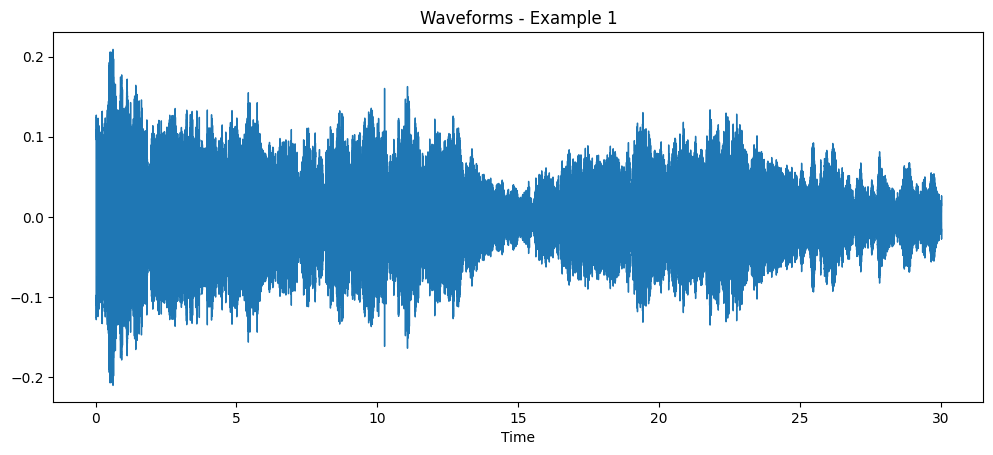

genre:  classical


In [15]:
id = 2
# Selecting array sound & sampling rate
array = df['train'][id]['audio']['array']
sampling_rate = df['train'][id]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - Example 1')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

# Printing genre
print("genre: ", id2label_function(df['train'][id]['genre']))

In [16]:
Audio(data = array, rate = sampling_rate)

In [17]:
def plot_history(history):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylim([0.0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'])

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'])

## Data Augmentation

In [18]:
def random_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps=pitch_factor)

def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal

In [19]:
train_dict = {}

for i, item in enumerate(df['train']):
    train_dict[i] = item

train_dict[0]

{'file': 'C:\\Users\\andre\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\\genres\\hiphop\\hiphop.00048.wav',
 'audio': {'path': 'C:\\Users\\andre\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\\genres\\hiphop\\hiphop.00048.wav',
  'array': array([-0.00500488, -0.00332642, -0.00518799, ..., -0.1675415 ,
          0.05627441,  0.11383057]),
  'sampling_rate': 22050},
 'genre': 4}

In [20]:
length = len(train_dict)

for id in range(length):
    instance = train_dict[id]

    audio = instance['audio']['array']
    genre = instance['genre']

    noised = random_noise(audio, 0.05)
    pitched = pitch(audio, 22050, 10)
    gained = random_gain(audio)

    inst = {'file':'none', 'audio':{'path':'none','array': np.array(noised), 'sampling_rate':22050}, 'genre':genre}
    inst1 = {'file':'none','audio':{'path':'none', 'array':np.array(pitched), 'sampling_rate':22050}, 'genre':genre}
    inst2 = {'file':'none','audio':{'path':'none', 'array': np.array(gained), 'sampling_rate':22050}, 'genre':genre}

    train_dict[length] = inst
    train_dict[length+1] = inst1
    train_dict[length+2] = inst2

    length += 3

In [21]:
len(train_dict)

2996

## Fast Fourier Transformation

In [17]:
def compute_fft(audio_arrays, sampling_rate):
    """
    Calcola la FFT e le frequenze corrispondenti per ogni traccia audio.
    
    :param audio_arrays: Lista di array audio
    :param sampling_rate: Frequenza di campionamento
    :return: Tuple contenente la lista dei risultati FFT e la lista delle frequenze
    """
    fft_results = [np.fft.fft(audio) for audio in audio_arrays]
    freqs = [np.fft.fftfreq(len(audio), 1 / sampling_rate) for audio in audio_arrays]
    return fft_results, freqs

train = [df['train'][id]['audio']['array'] for id in range(len(df['train']))]
validation = [df['validation'][id]['audio']['array'] for id in range(len(df['validation']))]
test = [df['test'][id]['audio']['array'] for id in range(len(df['test']))]

fft_train, freqs_train = compute_fft(train, sampling_rate)
fft_validation, freqs_validation = compute_fft(validation, sampling_rate)
fft_test, freqs_test = compute_fft(test, sampling_rate)

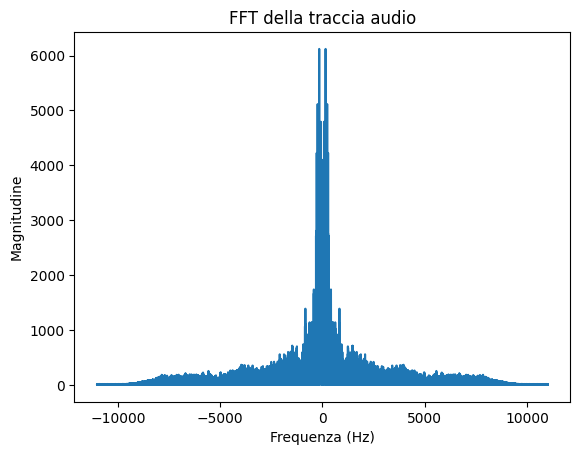

In [18]:
plt.plot(freqs_validation[0], np.abs(fft_validation[0]))
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Magnitudine')
plt.title('FFT della traccia audio')
plt.show()

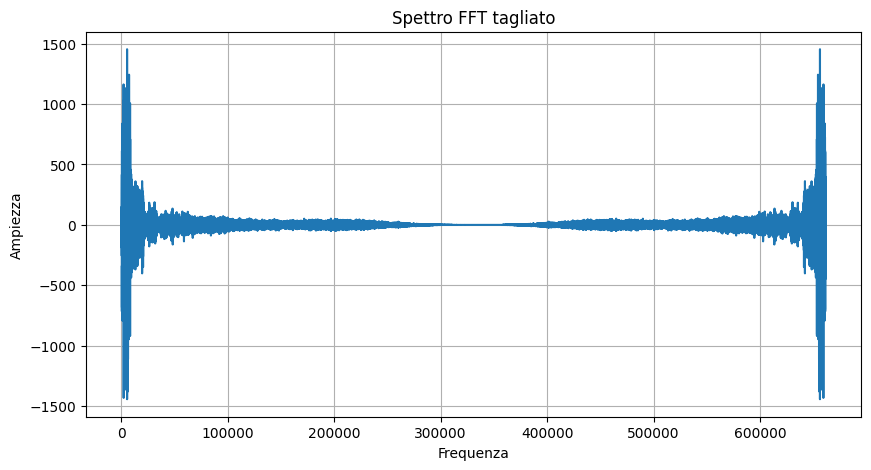

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.real(fft_train[0]))  # Sostituisci con un altro indice se necessario
plt.xlabel("Frequenza")
plt.ylabel("Ampiezza")
plt.title("Spettro FFT tagliato")
plt.grid()
plt.show()

In [20]:
a = []
for el in fft_train:
    a.append(len(el))

min(a)

660000

In [21]:
def cut_fourier(fft_result, max_freq=660000):
    """
    Taglia la FFT e le frequenze a max_freq
    """
    input = np.real(fft_result)
    output = input[:max_freq]
    return output

fft_train_cut = [cut_fourier(fft_result) for fft_result in fft_train]
fft_validation_cut = [cut_fourier(fft_result) for fft_result in fft_validation]
fft_test_cut = [cut_fourier(fft_result) for fft_result in fft_test]

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



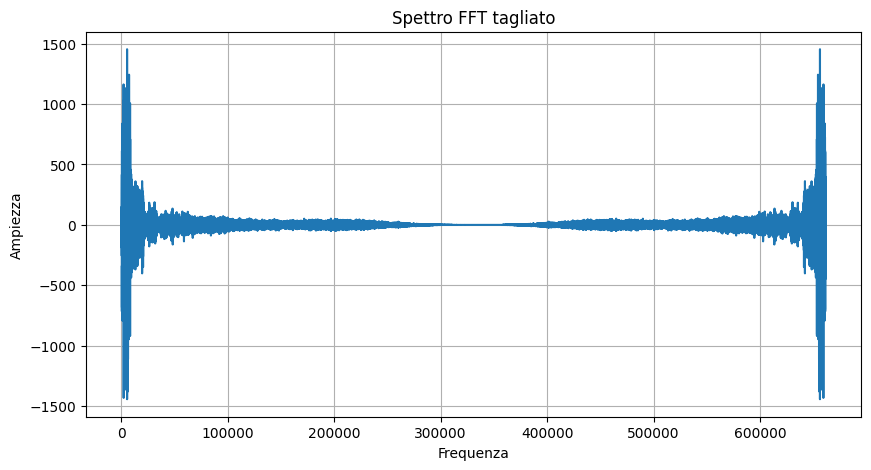

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(fft_train[0])  # Sostituisci con un altro indice se necessario
plt.xlabel("Frequenza")
plt.ylabel("Ampiezza")
plt.title("Spettro FFT tagliato")
plt.grid()
plt.show()

### FNN with Fourier

In [23]:
ground_truth_train = [df['train'][id]['genre'] for id in range(len(df['train']))]
ground_truth_validation = [df['validation'][id]['genre'] for id in range(len(df['validation']))]
ground_truth_test = [df['test'][id]['genre'] for id in range(len(df['test']))]

In [26]:
id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}
print("Mapping Generi:", genre_mapping)

# Normalizzazione delle FFT trasformate
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(fft_train_cut))
X_validation = scaler.transform(np.array(fft_validation_cut))
X_test = scaler.transform(np.array(fft_test_cut))

# Encoding delle etichette (da ID a one-hot)
y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)

# Definizione della rete neurale
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/fft_mod.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback
]

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=15, batch_size=32, callbacks=callbacks)

Mapping Generi: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1047 - loss: 12.7379
Epoch 1: val_accuracy improved from -inf to 0.17000, saving model to weights/fft_mod.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.1050 - loss: 12.9086 - val_accuracy: 0.1700 - val_loss: 4.3621 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2323 - loss: 78.6756
Epoch 2: val_accuracy did not improve from 0.17000
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2326 - loss: 78.2587 - val_accuracy: 0.0700 - val_loss: 3.4823 - learning_rate: 0.0010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2962 - loss: 51.9389
Epoch 3: val_accuracy did not improve from 0.17000
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2966 - loss: 51.7872 - val_accuracy: 0.0800 - val_loss: 3.2536 - learning_rate: 0.0010
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2975 - loss: 36.9110
Epoch 4: val_accuracy did not improve from 0.

In [34]:
model.load_weights('weights/fft_mod.weights.h5')  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


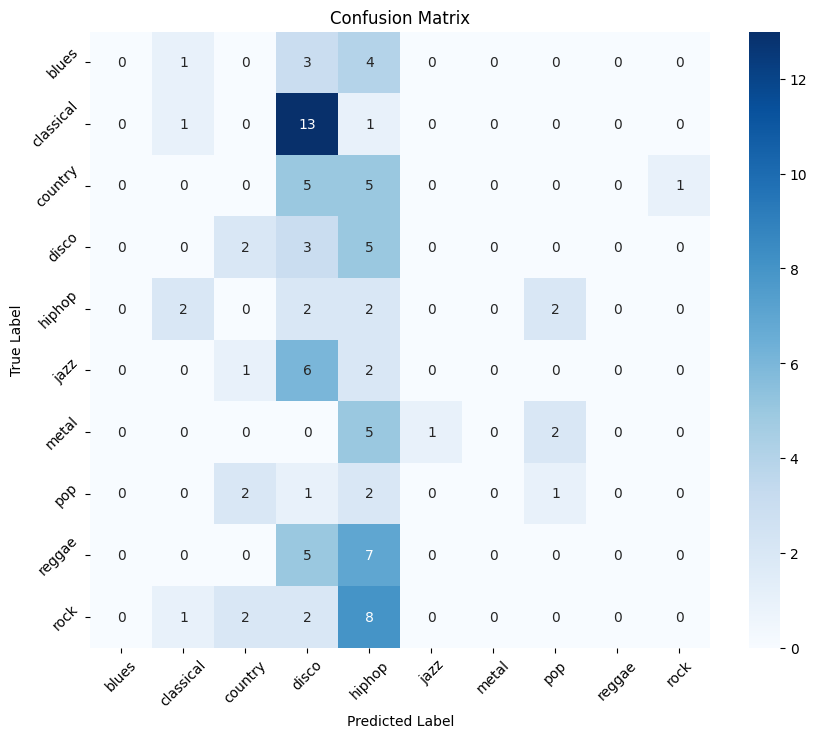


Classification Report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         8
   classical       0.20      0.07      0.10        15
     country       0.00      0.00      0.00        11
       disco       0.07      0.30      0.12        10
      hiphop       0.05      0.25      0.08         8
        jazz       0.00      0.00      0.00         9
       metal       0.00      0.00      0.00         8
         pop       0.20      0.17      0.18         6
      reggae       0.00      0.00      0.00        12
        rock       0.00      0.00      0.00        13

    accuracy                           0.07       100
   macro avg       0.05      0.08      0.05       100
weighted avg       0.05      0.07      0.04       100



c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [35]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = np.argmax(y_test, axis=1)  # Converti one-hot in classi

# Genera la confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Etichette dei generi per asse x/y
genre_labels = [genre_mapping[g] for g in unique_genre_ids]

# Plot della Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Report di classificazione
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genre_labels))


## MFCC

### Creation of MFCC representations

In [22]:
ground_truth_train = [train_dict[id]['genre'] for id in range(len(train_dict))]
ground_truth_validation = [df['validation'][id]['genre'] for id in range(len(df['validation']))]
ground_truth_test = [df['test'][id]['genre'] for id in range(len(df['test']))]

In [23]:
len(ground_truth_train), len(ground_truth_validation), len(ground_truth_test)

(2996, 125, 125)

In [24]:
len(train_dict)

2996

In [25]:
print(train_dict[0])

{'file': 'C:\\Users\\andre\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\\genres\\hiphop\\hiphop.00048.wav', 'audio': {'path': 'C:\\Users\\andre\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\\genres\\hiphop\\hiphop.00048.wav', 'array': array([-0.00500488, -0.00332642, -0.00518799, ..., -0.1675415 ,
        0.05627441,  0.11383057]), 'sampling_rate': 22050}, 'genre': 4}


In [26]:
def compute_mfcc(audio_arrays, sampling_rate, n_mfcc=64):
    """
    Calcola gli MFCC per ogni traccia audio.
    
    :param audio_arrays: Lista di array audio
    :param sampling_rate: Frequenza di campionamento
    :param n_mfcc: Numero di coefficienti MFCC da estrarre (default 10)
    :return: Lista dei coefficienti MFCC per ogni traccia audio
    """
    mfcc_results = [librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=n_mfcc) for audio in audio_arrays]
    return mfcc_results

# Prepara gli array audio per il training, validazione e test
train = [train_dict[id]['audio']['array'] for id in range(len(train_dict))]
validation = [df['validation'][id]['audio']['array'] for id in range(len(df['validation']))]
test = [df['test'][id]['audio']['array'] for id in range(len(df['test']))]

# Calcola gli MFCC per i dati di addestramento, validazione e test
mfcc_train = compute_mfcc(train, sampling_rate)
mfcc_validation = compute_mfcc(validation, sampling_rate)
mfcc_test = compute_mfcc(test, sampling_rate)

# Puoi visualizzare la dimensione degli MFCC per confermare il risultato
print(f"MFCC Train shape: {mfcc_train[0].shape}")
print(f"MFCC Validation shape: {mfcc_validation[0].shape}")
print(f"MFCC Test shape: {mfcc_test[0].shape}")

MFCC Train shape: (64, 1293)
MFCC Validation shape: (64, 1293)
MFCC Test shape: (64, 1293)


In [27]:
def cut_mfcc(mfcc_results, target_n_frames=1024):
    """
    Taglia o fa il padding delle matrici MFCC per ottenere una dimensione fissa di (10, 1293) per ogni traccia audio.
    
    :param mfcc_results: Lista di matrici MFCC (una per ogni traccia audio)
    :param target_n_frames: Numero target di frame (default 1024)
    :return: Lista di matrici MFCC tagliate o con padding (shape: [target_n_mfcc, target_n_frames])
    """
    mfcc_cut_results = []
    
    for mfcc in mfcc_results:
        # Seleziona solo i primi 1293 frame
        mfcc = mfcc[:, :target_n_frames]
        
        # Se la matrice ha meno di 1293 frame, aggiungi padding con zeri
        if mfcc.shape[1] < target_n_frames:
            padding = np.zeros((mfcc.shape[0], target_n_frames - mfcc.shape[1]))
            mfcc = np.hstack([mfcc, padding])
        
        # Aggiungi la matrice MFCC tagliata alla lista dei risultati
        mfcc_cut_results.append(mfcc)
    
    return mfcc_cut_results

# Esegui il cut su tutte le tracce MFCC
mfcc_train_cut = cut_mfcc(mfcc_train)
mfcc_validation_cut = cut_mfcc(mfcc_validation)
mfcc_test_cut = cut_mfcc(mfcc_test)

# Verifica la forma degli MFCC tagliati
print(f"MFCC Train Cut shape: {mfcc_train_cut[0].shape}")
print(f"MFCC Validation Cut shape: {mfcc_validation_cut[0].shape}")
print(f"MFCC Test Cut shape: {mfcc_test_cut[0].shape}")

MFCC Train Cut shape: (64, 1024)
MFCC Validation Cut shape: (64, 1024)
MFCC Test Cut shape: (64, 1024)


### Model

In [ ]:
X_train = np.array(mfcc_train_cut)  # Matrici MFCC per il training
X_validation = np.array(mfcc_validation_cut)  # Matrici MFCC per la validazione
X_test = np.array(mfcc_test_cut)  # Matrici MFCC per il test

y_train = np.array(ground_truth_train)  # Etichette del training
y_validation = np.array(ground_truth_validation)  # Etichette della validazione
y_test = np.array(ground_truth_test)  # Etichette del test

# Definisci il numero di classi
n_classes = len(np.unique(y_train))  # Numero di generi distinti

id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)

# Definizione della rete neurale
model = Sequential([
    Input(shape=(64,1024,1)),
    Convolution2D(32, (3,5), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Convolution2D(64, (3,5), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Convolution2D(128, (3,5), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Flatten(),
    Dense(64),
    Dropout(0.4),
    BatchNormalization(),
    Activation("relu"),
    Dense(n_classes, activation=softmax)
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/mfcc_mod.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback
]

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=15, batch_size=32, callbacks=callbacks)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1955 - loss: 2.2119
Epoch 1: val_accuracy improved from -inf to 0.24000, saving model to weights/mfcc_mod.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.1963 - loss: 2.2097 - val_accuracy: 0.2400 - val_loss: 2.1178 - learning_rate: 0.0010
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5053 - loss: 1.4791
Epoch 2: val_accuracy improved from 0.24000 to 0.45600, saving model to weights/mfcc_mod.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5058 - loss: 1.4780 - val_accuracy: 0.4560 - val_loss: 1.5555 - learning_rate: 0.0010
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7499 - loss: 0.9400
Epoch 3: val_accuracy did not improve from 0.45600
94/94 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7503 - loss: 0.9389 - val_accuracy: 0.4080 - val_loss: 1.6607 - learning_rate: 0.0010
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9162 - loss: 0.4943


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step


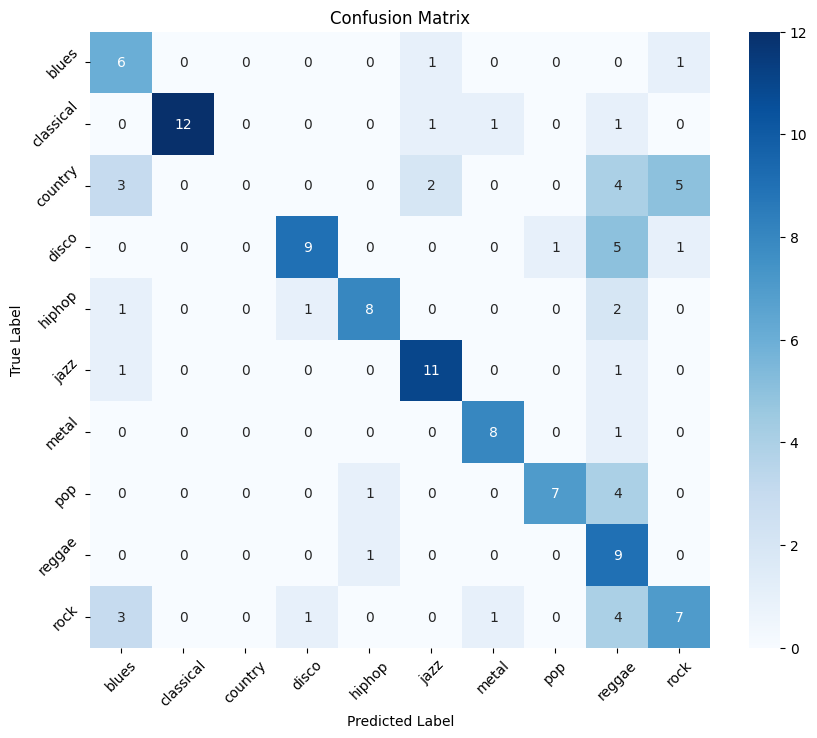


Classification Report:
              precision    recall  f1-score   support

       blues       0.43      0.75      0.55         8
   classical       1.00      0.80      0.89        15
     country       0.00      0.00      0.00        14
       disco       0.82      0.56      0.67        16
      hiphop       0.80      0.67      0.73        12
        jazz       0.73      0.85      0.79        13
       metal       0.80      0.89      0.84         9
         pop       0.88      0.58      0.70        12
      reggae       0.29      0.90      0.44        10
        rock       0.50      0.44      0.47        16

    accuracy                           0.62       125
   macro avg       0.62      0.64      0.61       125
weighted avg       0.63      0.62      0.60       125



c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [31]:
model.load_weights('weights/mfcc_mod.weights.h5')  
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = np.argmax(y_test, axis=1)  # Converti one-hot in classi

# Genera la confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Etichette dei generi per asse x/y
genre_labels = [genre_mapping[g] for g in unique_genre_ids]

# Plot della Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Report di classificazione
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genre_labels))